In [1]:
import wikipedia, requests, random, pycm, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
from IPython.display import display, Markdown
from classification_procedure import ClassificationProcedure

### Classification procedures

In [2]:
oed_planet = ClassificationProcedure(
    "OED",
    "planet", 
    """Any of various rocky or gaseous bodies that revolve in approximately elliptical orbits 
around the sun and are visible by its reflected light; esp. each of the planets Mercury, Venus, 
Earth, Mars, Jupiter, Saturn, Uranus, Neptune, and (until 2006) Pluto (in order of increasing 
distance from the sun); a similar body revolving around another star. Also: any of various 
smaller bodies that revolve around these (cf. satellite n. 2a)."""
)

iau_2006_8_16_planet = ClassificationProcedure(
    "IAU 2006-08-16",
    "planet", 
    """A planet is a celestial body that (a) has sufficient mass for its self-gravity to 
overcome rigid body forces so that it assumes a hydrostatic equilibrium (nearly round) shape, 
and (b) is in orbit around a star, and is neither a star nor a satellite of a planet."""
)

iau_2006_8_24_planet = ClassificationProcedure(
    "IAU 2006-08-24",
    "planet", 
    """A planet [1] is a celestial body that (a) is in orbit around the Sun, (b) has sufficient 
mass for its self-gravity to overcome rigid body forces so that it assumes a hydrostatic 
equilibrium (nearly round) shape, and (c) has cleared the neighbourhood around its orbit."""
)

#### Example in Figure 1

In [3]:
iau_2006_8_24_planet.classify("DENIS-P J082303.1−491201 b", "DENIS-P J082303.1-491201 b (alias 2MASS J08230313-4912012 b) is a substellar object, classified as either an exoplanet or a brown dwarf, orbiting DENIS-P J082303.1-491201, an L1.5-type brown dwarf in the constellation Vela.")

{'concept': 'planet',
 'definition': 'A planet [1] is a celestial body that (a) is in orbit around the Sun, (b) has sufficient \nmass for its self-gravity to overcome rigid body forces so that it assumes a hydrostatic \nequilibrium (nearly round) shape, and (c) has cleared the neighbourhood around its orbit.',
 'entity': 'DENIS-P J082303.1−491201 b',
 'description': 'DENIS-P J082303.1-491201 b (alias 2MASS J08230313-4912012 b) is a substellar object, classified as either an exoplanet or a brown dwarf, orbiting DENIS-P J082303.1-491201, an L1.5-type brown dwarf in the constellation Vela.',
 'rationale': 'The description of DENIS-P J082303.1−491201 b indicates that it is a substellar object that orbits DENIS-P J082303.1-491201, which is similar to the definition of a planet that states it is a celestial body in orbit around the Sun. Although the object in question is orbiting a brown dwarf and not the Sun, it is still in a similar orbital relationship. However, without additional informa

### Wikidata queries

In [4]:
KNOWLEDGE_GRAPH = "https://query.wikidata.org/sparql"

QUERY_HEADERS = {
    'User-Agent': 'ConceptualEngineeringAgent/0.2 (https://github.com/bradleypallen/conceptual-engineering-using-llms; b.p.allen@uva.nl)',
}

SAMPLE_SIZE = 5

POSITIVE_EXAMPLES_QUERY = """SELECT DISTINCT ?entity ?name ?article WHERE {
  {
    ?entity p:P31/ps:P31/wdt:P279* wd:Q634 .
    ?article schema:about ?entity ;
            schema:inLanguage "en" ;
            schema:isPartOf <https://en.wikipedia.org/> ;
            schema:name ?name .
  }
} LIMIT 10000"""

NEGATIVE_EXAMPLES_QUERY = """SELECT DISTINCT ?entity ?name ?article WHERE {
  {
    ?entity p:P31/ps:P31/wdt:P279* wd:Q3132741 .
    ?article schema:about ?entity ;
            schema:inLanguage "en" ;
            schema:isPartOf <https://en.wikipedia.org/> ;
            schema:name ?name .
    FILTER NOT EXISTS { ?entity p:P31/ps:P31 wd:Q634 }
  }
} LIMIT 10000"""

### Example entities

In [5]:
response = requests.get(KNOWLEDGE_GRAPH, params={'query' : POSITIVE_EXAMPLES_QUERY, 'format' : 'json'}, headers=QUERY_HEADERS)
response.raise_for_status()
json = response.json()
records = [ [ result["entity"]["value"], result["name"]["value"], result["article"]["value"] ] for result in json["results"]["bindings"] ]
records = random.sample(records, SAMPLE_SIZE)
positive_examples = pd.DataFrame.from_records(records, columns=["id", "name", "article"])
positive_examples["description"] = positive_examples["name"].apply(lambda name: wikipedia.summary(name, auto_suggest=False).replace('"', r'\"').strip()) 
positive_examples["actual"] = "positive"

In [6]:
response = requests.get(KNOWLEDGE_GRAPH, params={'query' : NEGATIVE_EXAMPLES_QUERY, 'format' : 'json'}, headers=QUERY_HEADERS)
response.raise_for_status()
json = response.json()
records = [ [ result["entity"]["value"], result["name"]["value"], result["article"]["value"] ] for result in json["results"]["bindings"] ]
records = random.sample(records, SAMPLE_SIZE)
negative_examples = pd.DataFrame.from_records(records, columns=["id", "name", "article"])
negative_examples["description"] = negative_examples["name"].apply(lambda name: wikipedia.summary(name, auto_suggest=False).replace('"', r'\"').strip()) 
negative_examples["actual"] = "negative"

In [7]:
examples = pd.concat([positive_examples, negative_examples], ignore_index=True)
examples

,id,name,article,description,actual
0,http://www.wikidata.org/entity/Q25377474,HD 159243 b,https://en.wikipedia.org/wiki/HD_159243_b,This is a List of exoplanets discovered in 201...,positive
1,http://www.wikidata.org/entity/Q94518130,HD 203949 b,https://en.wikipedia.org/wiki/HD_203949_b,HD 203949 is a K-type giant star 257 light-yea...,positive
2,http://www.wikidata.org/entity/Q94263131,HD 34445 e,https://en.wikipedia.org/wiki/HD_34445_e,HD 34445 is a star with multiple exoplanetary ...,positive
3,http://www.wikidata.org/entity/Q1039883,HD 101930 b,https://en.wikipedia.org/wiki/HD_101930_b,HD 101930 b is an extrasolar planet orbiting t...,positive
4,http://www.wikidata.org/entity/Q858156,DP Leonis b,https://en.wikipedia.org/wiki/DP_Leonis_b,DP Leonis (abbreviated DP Leo) is a binary sta...,positive
5,http://www.wikidata.org/entity/Q2611570,23011 Petach,https://en.wikipedia.org/wiki/23011_Petach,The following is a partial list of minor plane...,negative
6,http://www.wikidata.org/entity/Q286079,8687 Caussols,https://en.wikipedia.org/wiki/8687_Caussols,The following is a partial list of minor plane...,negative
7,http://www.wikidata.org/entity/Q158046,926 Imhilde,https://en.wikipedia.org/wiki/926_Imhilde,926 Imhilde (prov. designation: A920 CB or 192...,negative
8,http://www.wikidata.org/entity/Q2562254,20019 Yukiotanaka,https://en.wikipedia.org/wiki/20019_Yukiotanaka,The following is a partial list of minor plane...,negative
9,http://www.wikidata.org/entity/Q20098022,C/2014 Q1 (PanSTARRS),https://en.wikipedia.org/wiki/C/2014_Q1_(PanST...,C/2014 Q1 (PanSTARRS) is a non-periodic/long p...,negative


### Experiments

In [8]:
def run_experiment(cp, examples):
    print(f'{cp.term} ({cp.id})')
    classifications = examples.to_dict("records")
    for entity in tqdm(classifications):
        classification = cp.classify(entity["name"], entity["description"])
        entity["rationale"] = classification["rationale"]
        entity["predicted"] = classification["answer"]
    return pd.DataFrame.from_records(classifications)

In [9]:
oed_planet_results = run_experiment(oed_planet, examples)

planet (OED)


100%|██████████| 10/10 [01:27<00:00,  8.76s/it]


In [10]:
iau_2006_8_16_planet_results = run_experiment(iau_2006_8_16_planet, examples)

planet (IAU 2006-08-16)


100%|██████████| 10/10 [01:18<00:00,  7.90s/it]


In [11]:
iau_2006_8_24_planet_results = run_experiment(iau_2006_8_24_planet, examples)

planet (IAU 2006-08-24)


100%|██████████| 10/10 [01:28<00:00,  8.81s/it]


### Performance metrics

In [12]:
oed_planet_cm = pycm.ConfusionMatrix(
    oed_planet_results["actual"].tolist(), 
    oed_planet_results["predicted"].tolist(), 
    digit=2, 
    classes=[ 'positive', 'negative' ]
)

iau_2006_8_16_planet_cm = pycm.ConfusionMatrix(
    iau_2006_8_16_planet_results["actual"].tolist(), 
    iau_2006_8_16_planet_results["predicted"].tolist(), 
    digit=2, 
    classes=[ 'positive', 'negative' ]
)

iau_2006_8_24_planet_cm = pycm.ConfusionMatrix(
    iau_2006_8_24_planet_results["actual"].tolist(), 
    iau_2006_8_24_planet_results["predicted"].tolist(), 
    digit=2, 
    classes=[ 'positive', 'negative' ]
)

In [13]:
cms = [
    (f'{oed_planet.term} ({oed_planet.id})', oed_planet_cm),
    (f'{iau_2006_8_16_planet.term} ({iau_2006_8_16_planet.id})', iau_2006_8_16_planet_cm),
    (f'{iau_2006_8_24_planet.term} ({iau_2006_8_24_planet.id})', iau_2006_8_24_planet_cm)
]

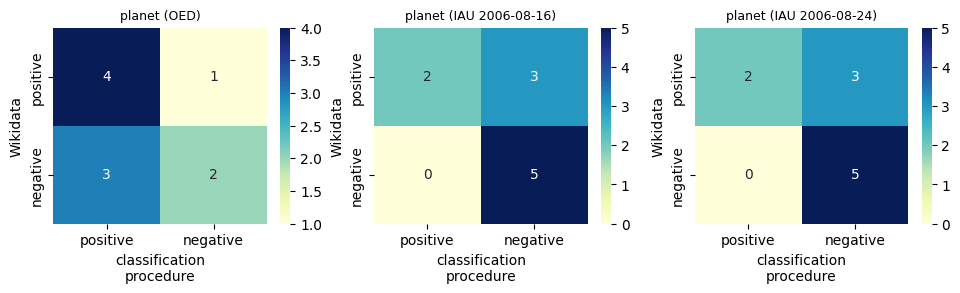

In [14]:
fig = plt.figure(figsize=(20,14))
gs = fig.add_gridspec(4, 5, hspace=0.5)
axes = gs.subplots()
for ax, (name, cm) in zip(axes.flat, cms):
    df = pd.DataFrame(cm.matrix).T.fillna(0)
    sns.heatmap(df, annot=True, fmt='d', cmap="YlGnBu", ax=ax)
    ax.set_title(name, wrap=True, fontsize=9)
    ax.set(xlabel='classification\nprocedure', ylabel='Wikidata')
for ax in axes.flat[len(cms):]:
    ax.set_visible(False)
plt.show()

In [15]:
metrics = pd.DataFrame.from_records([ 
    { "classification procedure": cm[0], "Cohen's kappa": cm[1].Kappa, "F1 macro": cm[1].F1_Macro, "FN": cm[1].FN["positive"], "FP": cm[1].FP["positive"] }
    for cm in cms 
])
metrics.sort_values(by="Cohen's kappa", ascending=False)

,classification procedure,Cohen's kappa,F1 macro,FN,FP
1,planet (IAU 2006-08-16),0.4,0.670330,3,0
2,planet (IAU 2006-08-24),0.4,0.670330,3,0
0,planet (OED),0.2,0.583333,1,3


### Error analyses

In [16]:
def display_errors(cp, results):
    display(Markdown(f'## {cp.term} ({cp.id})'))
    display(Markdown(f'Definition: {cp.definition}'))
    fns = results[((results["actual"] == 'positive') & (results["predicted"] == 'negative'))][["name", "description", "rationale"]]
    if len(fns) > 0:
        fns_styler = fns.style.set_properties(**{"text-align": "left", "vertical-align" : "top", "overflow-wrap": "break-word"}).hide(axis="index")
        display(Markdown(f'### False negatives'))
        display(fns_styler)
    fps = results[((results["actual"] == 'negative') & (results["predicted"] == 'positive'))][["name", "description", "rationale"]]
    if len(fps) > 0:
        fps_styler = fps.style.set_properties(**{"text-align": "left", "vertical-align" : "top", "overflow-wrap": "break-word"}).hide(axis="index")
        display(Markdown(f'### False positives'))
        display(fps_styler)


In [17]:
display_errors(oed_planet, oed_planet_results)

## planet (OED)

Definition: Any of various rocky or gaseous bodies that revolve in approximately elliptical orbits 
around the sun and are visible by its reflected light; esp. each of the planets Mercury, Venus, 
Earth, Mars, Jupiter, Saturn, Uranus, Neptune, and (until 2006) Pluto (in order of increasing 
distance from the sun); a similar body revolving around another star. Also: any of various 
smaller bodies that revolve around these (cf. satellite n. 2a).

### False negatives

name,description,rationale
HD 203949 b,"HD 203949 is a K-type giant star 257 light-years away in the constellation of Microscopium. Its surface temperature is 4618±113 K. It is either on the red giant branch fusing hydrogen in a shell around a helium core, or more likely a red clump star currently fusing helium in its core. HD 203949 is enriched in heavy elements relative to the Sun, with a metallicity ([Fe/H]) of 0.17±0.07 dex. As is common for red giants, HD 203949 has an enhanced concentration of sodium and aluminium compared to iron.Multiplicity surveys did not find any stellar companions around HD 203949 as of 2019.","The concept definition of a planet states that it is a body that revolves in approximately elliptical orbits around the sun or a similar body revolving around another star. While the entity description does not explicitly state that HD 203949 b is a planet, it does mention that HD 203949 is a star and does not mention any other stellar companions as of 2019. This could imply that HD 203949 b is a body revolving around the star HD 203949, which would align with the definition of a planet. However, without more specific information about HD 203949 b, it is not possible to definitively assert that it is a planet."


### False positives

name,description,rationale
23011 Petach,"The following is a partial list of minor planets, running from minor-planet number 23001 through 24000, inclusive. The primary data for this and other partial lists is based on JPL's \""Small-Body Orbital Elements\"" and \""Data Available from the Minor Planet Center\"". A detailed description of the table's columns and additional sources are given on the main page including a complete list of every page in this series, and a statistical break-up on the dynamical classification of minor planets. Also see the summary list of all named bodies in numerical and alphabetical order, and the corresponding naming citations for the number range of this particular list. New namings may only be added to this list after official publication, as the preannouncement of names is condemned by the Working Group for Small Bodies Nomenclature of the International Astronomical Union.","The definition of a planet includes any of various smaller bodies that revolve around larger bodies such as the sun. The description of 23011 Petach indicates that it is a minor planet, which falls under the category of smaller bodies. Therefore, based on the provided definition, 23011 Petach can be considered a planet."
8687 Caussols,"The following is a partial list of minor planets, running from minor-planet number 8001 through 9000, inclusive. The primary data for this and other partial lists is based on JPL's \""Small-Body Orbital Elements\"" and \""Data Available from the Minor Planet Center\"". A detailed description of the table's columns and additional sources are given on the main page including a complete list of every page in this series, and a statistical break-up on the dynamical classification of minor planets. Also see the summary list of all named bodies in numerical and alphabetical order, and the corresponding naming citations for the number range of this particular list. New namings may only be added to this list after official publication, as the preannouncement of names is condemned by the Working Group for Small Bodies Nomenclature of the International Astronomical Union.","The definition of a planet includes any of various smaller bodies that revolve around larger bodies, such as the sun. The description of 8687 Caussols indicates that it is a minor planet, which falls under the broader category of planets as defined. Therefore, based on the provided definition, one could argue that 8687 Caussols is a planet."
20019 Yukiotanaka,"The following is a partial list of minor planets, running from minor-planet number 20001 through 21000, inclusive. The primary data for this and other partial lists is based on JPL's \""Small-Body Orbital Elements\"" and \""Data Available from the Minor Planet Center\"". A detailed description of the table's columns and additional sources are given on the main page including a complete list of every page in this series, and a statistical break-up on the dynamical classification of minor planets. Also see the summary list of all named bodies in numerical and alphabetical order, and the corresponding naming citations for the number range of this particular list. New namings may only be added to this list after official publication, as the preannouncement of names is condemned by the Working Group for Small Bodies Nomenclature of the International Astronomical Union.","The definition provided for a planet states that it is a rocky or gaseous body that revolves in approximately elliptical orbits around the sun and is visible by its reflected light. The entity 20019 Yukiotanaka is described as a minor planet, which implies that it is a smaller body that revolves around the sun. Therefore, based on the provided definition, one could argue that 20019 Yukiotanaka is a planet. However, it should be noted that the definition also includes a reference to the specific planets in our solar system and a similar body revolving around another star, which may not necessarily apply to 20019 Yuki

In [18]:
display_errors(iau_2006_8_16_planet, iau_2006_8_16_planet_results)

## planet (IAU 2006-08-16)

Definition: A planet is a celestial body that (a) has sufficient mass for its self-gravity to 
overcome rigid body forces so that it assumes a hydrostatic equilibrium (nearly round) shape, 
and (b) is in orbit around a star, and is neither a star nor a satellite of a planet.

### False negatives

name,description,rationale
HD 159243 b,"This is a List of exoplanets discovered in 2013. For exoplanets detected only by radial velocity, the mass value is actually a lower limit. (See Minimum mass for more information)","The text does not provide enough information to definitively assert that HD 159243 b is a planet. While it is mentioned in a list of exoplanets discovered in 2013, the text does not provide specific details about HD 159243 b's mass, shape, or its orbit around a star, which are necessary to classify it as a planet according to the provided definition."
HD 203949 b,"HD 203949 is a K-type giant star 257 light-years away in the constellation of Microscopium. Its surface temperature is 4618±113 K. It is either on the red giant branch fusing hydrogen in a shell around a helium core, or more likely a red clump star currently fusing helium in its core. HD 203949 is enriched in heavy elements relative to the Sun, with a metallicity ([Fe/H]) of 0.17±0.07 dex. As is common for red giants, HD 203949 has an enhanced concentration of sodium and aluminium compared to iron.Multiplicity surveys did not find any stellar companions around HD 203949 as of 2019.","The provided description does not provide sufficient information to assert that HD 203949 b is a planet. The description primarily focuses on the characteristics of the star HD 203949, not a separate celestial body in orbit around it. Therefore, based on the given information, we cannot definitively classify HD 203949 b as a planet."
HD 34445 e,"HD 34445 is a star with multiple exoplanetary companions in the equatorial constellation of Orion. With an apparent visual magnitude of 7.31, it is a 7th magnitude star that is too dim to be readily visible to the naked eye. The system is located at a distance of 150.5 light years from the Sun based on parallax measurements, but is drifting closer with a high radial velocity of −79 km/s. It is expected to draw as close as 57.5 light-years in ~492,000 years.This is an ordinary G-type main-sequence star with a stellar classification of G0 V, which means it is a Sun-like star that is generating energy through core hydrogen fusion. It is considered a metal-rich star, showing a much higher metallicity compared to the Sun. Despite this it is an older star and chromospherically quiet, lying about 0.8 magnitudes above the main sequence. This star is larger, hotter, brighter, and more massive than the Sun. It is spinning with a projected rotational velocity of ~3 km/s, giving it a rotation period of around 22 days.","The description does not provide sufficient information to assert that HD 34445 e is a planet. The description primarily focuses on the characteristics of the star HD 34445, not any specific celestial body orbiting it. To determine if HD 34445 e is a planet, we would need information about its mass, shape, and whether it orbits the star HD 34445 without being a star itself or a satellite of another planet. Without this information, we cannot definitively classify HD 34445 e as a planet."


In [19]:
display_errors(iau_2006_8_24_planet, iau_2006_8_24_planet_results)

## planet (IAU 2006-08-24)

Definition: A planet [1] is a celestial body that (a) is in orbit around the Sun, (b) has sufficient 
mass for its self-gravity to overcome rigid body forces so that it assumes a hydrostatic 
equilibrium (nearly round) shape, and (c) has cleared the neighbourhood around its orbit.

### False negatives

name,description,rationale
HD 159243 b,"This is a List of exoplanets discovered in 2013. For exoplanets detected only by radial velocity, the mass value is actually a lower limit. (See Minimum mass for more information)","The text does not provide sufficient information to assert that HD 159243 b is a planet based on the provided definition. The definition requires that the celestial body is in orbit around the Sun, has sufficient mass to assume a nearly round shape, and has cleared the neighbourhood around its orbit. The description of HD 159243 b does not provide any of this information."
HD 203949 b,"HD 203949 is a K-type giant star 257 light-years away in the constellation of Microscopium. Its surface temperature is 4618±113 K. It is either on the red giant branch fusing hydrogen in a shell around a helium core, or more likely a red clump star currently fusing helium in its core. HD 203949 is enriched in heavy elements relative to the Sun, with a metallicity ([Fe/H]) of 0.17±0.07 dex. As is common for red giants, HD 203949 has an enhanced concentration of sodium and aluminium compared to iron.Multiplicity surveys did not find any stellar companions around HD 203949 as of 2019.","The text does not provide sufficient information to assert that HD 203949 b is a planet. The description only provides information about the star HD 203949, not about any celestial bodies orbiting it. To classify HD 203949 b as a planet, we would need information confirming that it orbits around the star (HD 203949), has sufficient mass to maintain a nearly round shape due to its self-gravity, and has cleared its orbit's neighbourhood. Without this information, we cannot definitively classify HD 203949 b as a planet."
HD 34445 e,"HD 34445 is a star with multiple exoplanetary companions in the equatorial constellation of Orion. With an apparent visual magnitude of 7.31, it is a 7th magnitude star that is too dim to be readily visible to the naked eye. The system is located at a distance of 150.5 light years from the Sun based on parallax measurements, but is drifting closer with a high radial velocity of −79 km/s. It is expected to draw as close as 57.5 light-years in ~492,000 years.This is an ordinary G-type main-sequence star with a stellar classification of G0 V, which means it is a Sun-like star that is generating energy through core hydrogen fusion. It is considered a metal-rich star, showing a much higher metallicity compared to the Sun. Despite this it is an older star and chromospherically quiet, lying about 0.8 magnitudes above the main sequence. This star is larger, hotter, brighter, and more massive than the Sun. It is spinning with a projected rotational velocity of ~3 km/s, giving it a rotation period of around 22 days.","The provided description does not provide sufficient information to assert that HD 34445 e is a planet. The description primarily focuses on the characteristics of the star HD 34445, not any specific celestial bodies orbiting it. To classify HD 34445 e as a planet, we would need information confirming that it orbits the star (HD 34445), has sufficient mass to maintain a nearly round shape due to its self-gravity, and has cleared its orbit's neighbourhood. Without this information, we cannot definitively classify HD 34445 e as a planet."
